In [ ]:
from typing import Dict, List, Tuple, Callable
import traceback
import os

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import tqdm
import numpy as np
from matplotlib import pyplot as plt

class TrainerNeuroswipe:
    """
    Trains model, saves information about training

    The aim of the class is to incapsulate all the training process.
    It should be able to:
    - train model for given number of epochs
    - save Trainer state
        - model parameters
        - optimizer state
        - metric and loss history
        - epoch number 
    - load Trainer states
    - resume training from saved state
    - training features:
        - early stopping
        - learning rate scheduler

        
    Arguments:
    ----------
    model: nn.Module
    optimizer: torch.optim.Optimizer
    criterion: nn.Module
    save_path: str
        path to save Trainer state
    save_period: int
        number of epochs between saving Trainer state
    device: torch.device
        device to train on
    """

    PHASES = ('train', 'val')

    def __init__(self,
                 model: nn.Module,
                 criterion: nn.Module,
                 save_path: str,
                 train_dataloader: DataLoader,
                 val_dataloader: DataLoader,
                 metric_getters: Dict[str, Callable],
                 phase_to_metric_names: Dict[str, List[str]],
                 optimizer_ctor: Callable  = None,
                 lr_scheduler_ctor: Callable = None,
                 lr: float =1e-4,
                 save_period: int = 5,
                 l2_reg_alpha=0,
                 device: torch.device = None,
                 model_name: str = "",
                 model_save_root = "../..",
                 max_batches_per_epoch_train = 2000,
                 ) -> None:
        self.model_name = model_name
        
        if optimizer_ctor is None:
            self.optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
        else:
            self.optimizer = optimizer_ctor(model.parameters(), lr=lr)

        if lr_scheduler_ctor is not None:
            self.lr_scheduler = lr_scheduler_ctor(self.optimizer)
        else:
            self.lr_scheduler = None
        
        self.device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.criterion = criterion
        
        self.save_path = save_path
        self.save_period = save_period
        self.epoch = 0
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.metric_getters = metric_getters
        
        assert set(phase_to_metric_names.keys()) == set(self.PHASES)
        self.phase_to_metric_names = phase_to_metric_names
        
        
        self.history = {
            phase: {
                metric_name: []
                for metric_name in phase_to_metric_names[phase]
            }
            for phase in self.PHASES
        }
        for phase in self.PHASES:
            self.history[phase]['loss'] = []

        self.best_val_loss = float('inf')
        self.best_val_epoch_i = -1

        self.model_save_root = model_save_root
        self.max_batches_per_epoch_train = max_batches_per_epoch_train

        


    def train(self,
              n_epochs: int,
              early_stopping_patience: int =10):
        best_epoch_i = 0

        for epoch_i in tqdm(range(epoch_n), position = 0):
            try:
                self.model.train()
                mean_train_loss = 0
                train_batches_n = 0
                for batch_i, (batch_x, batch_y) in tqdm(enumerate(self.train_dataloader), total = min(self.max_batches_per_epoch_train, len(train_dataset) // batch_size), position=1, leave = False):
                    if batch_i > self.max_batches_per_epoch_train:
                        break

                    batch_x, batch_y = prepare_batch(batch_x, batch_y, device)

                    pred = model(*batch_x)
                    loss = criterion(pred, batch_y, ignore_index = criterion_ignore_index)

                    model.zero_grad()
                    loss.backward()

                    optimizer.step()

                    mean_train_loss += float(loss)
                    train_batches_n += 1

                mean_train_loss /= train_batches_n
                
                print('Среднее значение функции потерь на обучении', mean_train_loss)



                model.eval()
                mean_val_loss = 0
                val_batches_n = 0

                with torch.no_grad():
                    for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                        if batch_i > max_batches_per_epoch_val:
                            break

                        batch_x, batch_y = prepare_batch(batch_x, batch_y, device)

                        pred = model(*batch_x)
                        loss = criterion(pred, batch_y, ignore_index = criterion_ignore_index)

                        mean_val_loss += float(loss)
                        val_batches_n += 1

                mean_val_loss /= val_batches_n
                print('Среднее значение функции потерь на валидации', mean_val_loss)

                if mean_val_loss < best_val_loss:
                    best_epoch_i = epoch_i
                    best_val_loss = mean_val_loss
                    cur_time = "{:%Y_%m_%d__%H_%M_%S}".format(datetime.now())
                    torch.save(self.model.state_dict(), 
                               os.path.join(model_save_root,
                                            f"{self.model_name}__{cur_time}__{mean_val_loss:.5f}_{model_name_postfix}.pt"))
                    print('Новая лучшая модель!')
                elif epoch_i - best_epoch_i > early_stopping_patience:
                    print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                        early_stopping_patience))
                    break

                if lr_scheduler is not None:
                    lr_scheduler.step(mean_val_loss)

                print()
            except KeyboardInterrupt:
                print('Досрочно остановлено пользователем')
                break
            except Exception as ex:
                print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
                break




    def save(self, path: str) -> None:
        # We save whole model and optimizer instead of
        # state_dicts because this is a robust way
        # to save trainer state even if we update model
        # and optimizer.
        torch.save({
            'epoch': self.epoch,
            'model': self.model,
            'optimizer': self.optimizer,
            'history': self.history,
            'best_val_loss': self.best_val_loss
        }, path)


    def load(self, path: str) -> None:
        checkpoint = torch.load(path)
        self.epoch = checkpoint['epoch']
        # self.model.load_state_dict(checkpoint['model_state_dict'])
        # self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.model = checkpoint['model']
        self.optimizer = checkpoint['optimizer']
        self.history = checkpoint['history']
        self.best_val_loss = checkpoint['best_val_loss']
        self.model.to(self.device)


    def get_metrics(self,
                    preds: List[np.ndarray[float]],
                    targets: List[float],
                    phase: str
                    ) -> Dict[str, float]:
        metrics = {}
        for metric_name in self.phase_to_metric_names[phase]:
            metrics[metric_name] = self.metric_getters[metric_name](preds, targets)
        return metrics


    def update_history(self,
                       metrics: Dict[str, float],
                       loss: float,
                       phase: str
                       ) -> None:
        for metric_name in self.phase_to_metric_names[phase]:
            self.history[phase][metric_name].append(metrics[metric_name])
        self.history[phase]['loss'] = loss

    
    def validate(self) -> float:
        """Returns loss on validation dataset"""
        running_loss = 0.0
        with torch.no_grad():
            for seqs, labels in self.dataloaders['val']:
                seqs = seqs.to(self.device)
                labels = labels.to(self.device)
                out = self.model(seqs)
                running_loss += self.criterion(out.permute(0, 2, 1), labels).item()
        
        return running_loss / len(self.dataloaders['val'])

    
    def plot_history(self, figsize: Tuple[int, int] = (10, 5)):

        # fig, axs = plt.subplots(len(self.phases), len(metric_names), sharex=True, figsize=figsize, dpi=80)
        # for i, phase in enumerate(self.phases):
        #     for j, metric in enumerate(metric_names):
        #         axs[i, j].plot(self.history[phase][metric])
        #         axs[i, j].set_title(f'{phase} {metric}')
        # plt.show()

In [ ]:
        epoch_pbar = tqdm(range(n_epochs), position=0, leave = "True", desc='Epochs')
        for _ in epoch_pbar:
            epoch_pbar_str = f'epoch {self.epoch} '
            for phase in self.PHASES:
                running_loss = 0
                all_lables = []
                all_pred_logits = []

                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                with torch.set_grad_enabled(phase == 'train'):
                    batch_pbar = tqdm(self.dataloaders[phase], position=1, leave = "False",
                        desc=f"E{self.epoch} {phase.upper()} Batches")
                    
                    for wavs, label_seqs in batch_pbar:
                        wavs = wavs.to(self.device)
                        label_seqs = label_seqs.to(self.device)
                        out = self.model(wavs)

                        loss = self.criterion(out, label_seqs)
                        
                        if phase == 'train':
                            self.optimizer.zero_grad()
                            loss.backward()
                            self.optimizer.step()

                        running_loss += loss.item()
                        all_lables.extend(list(label_seqs.flatten().cpu().numpy()))
                        all_pred_logits.extend(list(out.reshape(-1, n_tokens).detach().cpu().numpy()))
                        
                        batch_pbar.set_postfix_str(f'loss {loss.item():.3f}')
                
                avg_loss = running_loss / len(self.dataloaders[phase])

                metrics = self.get_metrics(all_lables, all_pred_logits)

                metric_str_list = [f'{m_name}: {m_value:.3f}'
                    for m_name, m_value in metrics.items()]
                metrics_str = f"{', '.join(metric_str_list)}"
                epoch_pbar_str += f' {phase}: {metrics_str}'
                epoch_pbar.set_postfix_str(epoch_pbar_str)

                self.update_history(metrics, float(loss), phase)
                
                running_loss = 0

                if phase == 'val' and avg_loss < self.best_val_loss:
                    self.best_val_loss = avg_loss
                    self.save('best_model.pth')
            
            if self.epoch % self.save_period == 0:
                self.save(self.save_path)
            
            self.plot_history()

            self.epoch += 1

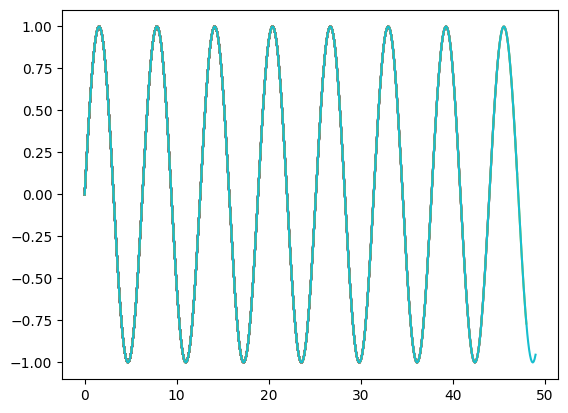

In [15]:
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from IPython import display

import time
import numpy as np

xx = list()

# display the initial figure and get a display handle
# (it starts out blank here)
fig, ax = plt.subplots()
dh = display.display(fig, display_id=True)

for i in range(500): # tqdm(range(500)):
    xx.append(i * 0.1)
    yy = np.sin(xx)

    if i % 10 == 0:
        # generate the plot and then update the
        # display handle to refresh it
        # display.clear_output(wait = True)
        ax.plot(xx, yy)
        # plt.show()
        dh.update(fig)
        
        time.sleep(0.1)

# close the figure at the end or else you
# end up with an extra plot
plt.close()